In [1]:
from __future__ import print_function
# standard packages
import numpy as np
import mdtraj as md
import pandas as pd
import math
import random
import time

import matplotlib.pyplot as plt

# OpenMM
from simtk.openmm import app
import simtk.unit as unit

# OpenMMTools
import openmmtools as omt

# OpenPathSampling
import openpathsampling as paths
from openpathsampling.tools import refresh_output

# Visualization of PathTrees
import openpathsampling.visualize as ops_vis
#from openpathsampling.visualize import PathTree
from IPython.display import SVG

# the openpathsampling OpenMM engine
import openpathsampling.engines.openmm as eng

# always the most complicated bit
import openpathsampling.engines.toy as toys
%run toy_plot_helpers_Z.py

from datetime import datetime

import pickle

np.set_printoptions(precision=3, suppress=True)

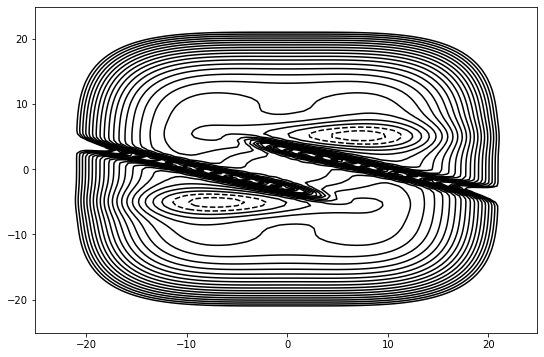

In [2]:
# defines potential energy landscape
# outer walls prevent the simulation to move past them by applying an exponential(?) potential
# Gaussian defines the two circular wells on the landscape

pes_Z = toys.ZPotential()
#pes = (toys.OuterWalls([1.0,1.0], [0.0,0.0]) + 
#       toys.Gaussian(-0.7, [7.5, 7.5], [-0.5, 0.0]) +
#       toys.Gaussian(-0.7, [7.5, 7.5], [0.5, 0.0]))

plot = ToyPlot()
# sets contour lines to user defined
plot.contour_range = np.arange(-1.5, 10.0, 0.5)
plot.add_pes(pes_Z)
plot.plot()

pass

In [3]:
topology_Z = toys.Topology(n_spatial=2, masses=[1.0, 1.0], pes=pes_Z)
toy_engine_Z = toys.Engine({'integ': toys.LangevinBAOABIntegrator(dt=0.2, temperature=1.0, gamma=1.0),
#toy_engine_Z = toys.Engine({'integ': toys.LangevinBAOABIntegrator(dt=0.1, temperature=0.5, gamma=1.0),
                              'n_frames_max': 50000,
                              'n_steps_per_frame': 1}, topology_Z)
template_Z = toys.Snapshot(coordinates=np.array([[0.0, 0.0]]),
                         velocities=np.array([[0.0, 0.0]]),
                        engine=toy_engine_Z)

In [4]:
# feeds in a current snapshot into the engine
toy_engine_Z.current_snapshot = template_Z
paths.PathMover.engine = toy_engine_Z

In [5]:
def circle(snapshot, center):
    import math
    return math.sqrt((snapshot.xyz[0][0]-center[0])**2
                     + (snapshot.xyz[0][1]-center[1])**2)
def disk(snapshot, center):
    import math
    return (snapshot.xyz[0][0]-center[0])**2/16 + (snapshot.xyz[0][1]-center[1])**2
# turns the circle function into a collective variable
# from collectivevariable.py
opA = paths.CoordinateFunctionCV(name="opA", f=disk, center=[-7.2, -5.1])
opB = paths.CoordinateFunctionCV(name="opB", f=disk, center=[7.2, 5.1])

In [6]:
# defines the volumes of state A and B as range of the circle functions
# with the respective center defined before
# from volume.py
stateA = paths.CVDefinedVolume(opA, 0.0, 0.25).named("A")
stateB = paths.CVDefinedVolume(opB, 0.0, 0.25).named("B")

In [7]:
# generate trajectory that includes frame in both states
n_frames = 1000000
long_trajectory_Z = toy_engine_Z.generate_n_frames(n_frames = n_frames)

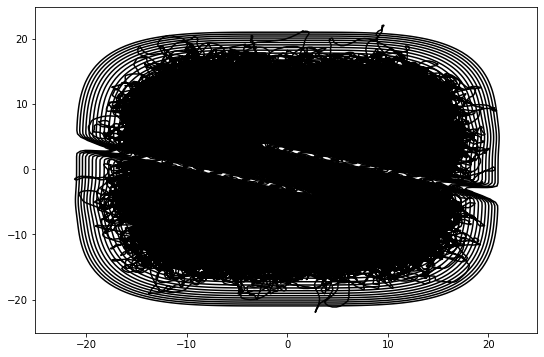

In [8]:
plot.plot([long_trajectory_Z])
#print(long_trajectory)
pass

In [9]:
# create a network so we can use its ensemble to obtain an initial trajectory
# use all-to-all because we don't care if initial traj is A->B or B->A: it can be reversed
#AB_network = paths.TPSNetwork.from_states_all_to_all([stateA, stateB])
# use this because we care about AB vs BA fpr the progress label
AB_network = paths.TPSNetwork(initial_states=stateA, final_states=stateB)
BA_network = paths.TPSNetwork(initial_states=stateB, final_states=stateA)
## take the subtrajectory matching the ensemble (only one ensemble, only one subtraj)


Ens_1InA = paths.IntersectionEnsemble(paths.AllInXEnsemble(stateA),paths.LengthEnsemble(1))
Ens_1InB = paths.IntersectionEnsemble(paths.AllInXEnsemble(stateB),paths.LengthEnsemble(1))
Ens_NotInAB = paths.IntersectionEnsemble(paths.AllOutXEnsemble(stateA), paths.AllOutXEnsemble(stateB))
AA_network = paths.SequentialEnsemble((Ens_1InA,Ens_NotInAB,Ens_1InA))
BB_network = paths.SequentialEnsemble((Ens_1InB,Ens_NotInAB,Ens_1InB))

print("Starting: AB")
#subtrajectories_AB = []
#for ens in AB_network.analysis_ensembles:
#    subtrajectories_AB += ens.split(long_trajectory_Z)
subtrajectories_AB = AB_network.analysis_ensembles[0].split(long_trajectory_Z)
print("Starting: BA")
subtrajectories_BA = BA_network.analysis_ensembles[0].split(long_trajectory_Z)
print("Starting: AA")
subtrajectories_AA = AA_network.split(long_trajectory_Z)
print("Starting: BB")
subtrajectories_BB = BB_network.split(long_trajectory_Z)
    
print(len(subtrajectories_AB))
print(len(subtrajectories_BA))
print(len(subtrajectories_AA))
print(len(subtrajectories_BB))

Starting: AB
Starting: BA
Starting: AA
Starting: BB
15
15
5875
7407


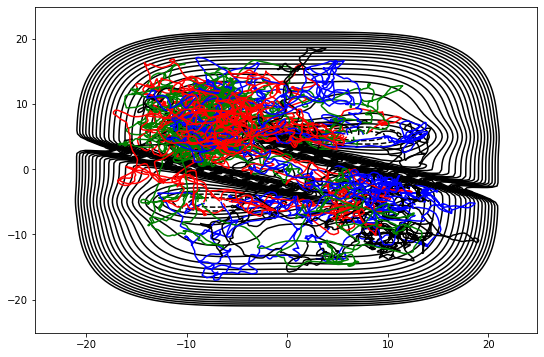

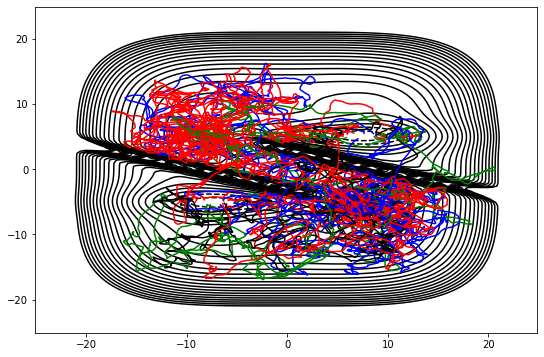

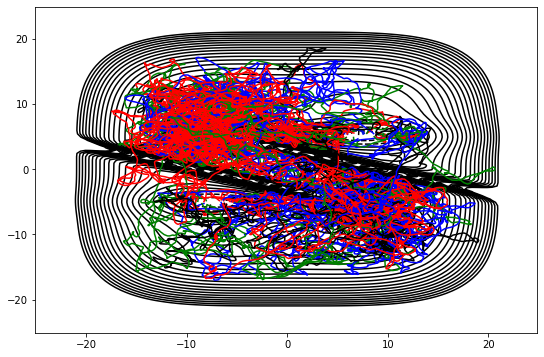

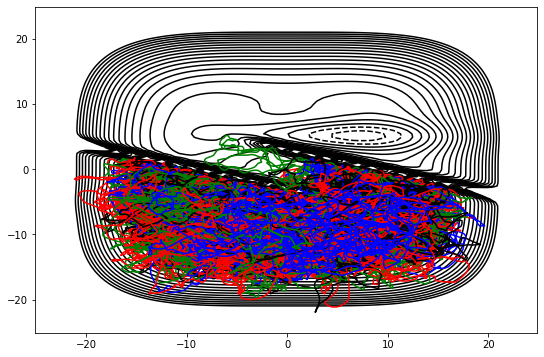

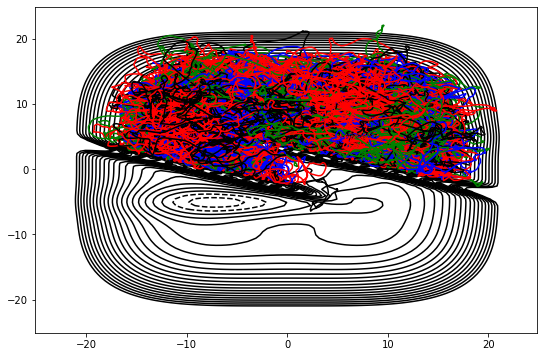

In [10]:
plot.plot(subtrajectories_AB)
plot.plot(subtrajectories_BA)
plot.plot(subtrajectories_AB+subtrajectories_BA)
plot.plot(subtrajectories_AA)
plot.plot(subtrajectories_BB)
pass

In [11]:
time_in_AA = sum([len(trajectory) for trajectory in subtrajectories_AA])
time_in_AB = sum([len(trajectory) for trajectory in subtrajectories_AB])
time_in_BA = sum([len(trajectory) for trajectory in subtrajectories_BA])
time_in_BB = sum([len(trajectory) for trajectory in subtrajectories_BB])
percentage_out_of_states = 100*sum([len(trajectory) for trajectory in \
        subtrajectories_AA + subtrajectories_AB + subtrajectories_BA + subtrajectories_BB])/len(long_trajectory_Z)

print("Simulation of {} steps was decomposed into:".format(len(long_trajectory_Z)))
print("{} steps ({}%) spend in total outside of the stable states.".format(time_in_AA+time_in_AB+time_in_BA+time_in_BB,percentage_out_of_states))
print("{} steps spend in AA trajectories.".format(time_in_AA))
print("{} steps spend in AB trajectories.".format(time_in_AB))
print("{} steps spend in BA trajectories.".format(time_in_BA))
print("{} steps spend in AB trajectories.".format(time_in_BB))



Simulation of 1000000 steps was decomposed into:
955422 steps (95.5422%) spend in total outside of the stable states.
401932 steps spend in AA trajectories.
21877 steps spend in AB trajectories.
18334 steps spend in BA trajectories.
513279 steps spend in AB trajectories.


In [12]:
pes_H = toys.HarmonicOscillator([1.0, 1.0], [1.0, 1.0], [0.0, 0.0])

topology_H = toys.Topology(n_spatial=2, masses=[1.0, 1.0], pes=pes_H)
toy_engine_H= toys.Engine({'integ': toys.LangevinBAOABIntegrator(dt=0.2, temperature=1.0, gamma=1.0),
                              'n_frames_max': 50000,
                              'n_steps_per_frame': 1}, topology_H)
template_H = toys.Snapshot(coordinates=np.array([[0.0, 0.0]]),
                         velocities=np.array([[0.0, 0.0]]),
                        engine=toy_engine_H)

toy_engine_H.current_snapshot = template_H
paths.PathMover.engine = toy_engine_H

In [13]:
short_len = time_in_AA+time_in_AB+time_in_BA+time_in_BB
short_trajectory_H1 = toy_engine_H.generate_n_frames(n_frames = short_len)
short_trajectory_H2 = toy_engine_H.generate_n_frames(n_frames = short_len)
short_trajectory_H3 = toy_engine_H.generate_n_frames(n_frames = short_len)
short_trajectory_H4 = toy_engine_H.generate_n_frames(n_frames = short_len)
#plot = ToyPlot()
#plot.plot([short_trajectory_H1])
#plot.plot([short_trajectory_H2])
#plot.plot([short_trajectory_H3])
#plot.plot([short_trajectory_H4])

In [14]:
# makes an array of arrays containing only the x and y positions of the system
# for each trajectory in the respective set of subtrajectories, an array is
# generated that consists of all x and y positions of that trajectory
# these arrays are all put together in one super-array for each of the subtrajectory sets
total_array_AA = np.array([np.array([xy_position[0] \
    for xy_position in trajectory.xyz]) \
    for trajectory in subtrajectories_AA])
total_array_AB = np.array([np.array([xy_position[0] \
    for xy_position in trajectory.xyz]) \
    for trajectory in subtrajectories_AB])
total_array_BA = np.array([np.array([xy_position[0] \
    for xy_position in trajectory.xyz]) \
    for trajectory in subtrajectories_BA])
total_array_BB = np.array([np.array([xy_position[0] \
    for xy_position in trajectory.xyz]) \
    for trajectory in subtrajectories_BB])


In [15]:
trajectory_list = np.array([trajectory for trajectory in total_array_AA]
                                +[trajectory for trajectory in total_array_AB]
                                +[trajectory for trajectory in total_array_BA]
                                +[trajectory for trajectory in total_array_BB])
trajectory_label_list = np.array([-1.0 for trajectory in total_array_AA]
                                      +[-0.5 for trajectory in total_array_AB]
                                      +[0.5 for trajectory in total_array_BA]
                                      +[1.0 for trajectory in total_array_BB])


In [16]:
# obtains the x and y positions of the harmonic oscillator runs
xy_positions_H1 = short_trajectory_H1.xyz[:,0]
xy_positions_H2 = short_trajectory_H2.xyz[:,0]
xy_positions_H3 = short_trajectory_H3.xyz[:,0]
xy_positions_H4 = short_trajectory_H4.xyz[:,0]

full_trajectory_list = []
# iterates over all trajectories in trajectory (only containing Z-Potential coordinates so far)
# takes slices of the harmonic oscillation trajectories and concatenates the Z-Potential positions
# with the harmonic potential positions
# This gives a total of 10 dimensions
c_o = 0
for Z_trajectory in trajectory_list:
    c_n = c_o + len(Z_trajectory)
    H1_trajectory = xy_positions_H1[c_o: c_n]
    H2_trajectory = xy_positions_H2[c_o: c_n]
    H3_trajectory = xy_positions_H3[c_o: c_n]
    H4_trajectory = xy_positions_H4[c_o: c_n]
    full_trajectory_list.append(np.concatenate((Z_trajectory,H1_trajectory, \
                                H2_trajectory, H3_trajectory, H4_trajectory),axis =1))
    c_o = c_n

trajectory_list = np.array(full_trajectory_list)
print(trajectory_list.shape)
#    print(len(i))

(13312,)


In [17]:
pickle.dump(trajectory_list, open("trajectory_list_3.p", "wb"))
pickle.dump(trajectory_label_list, open("trajectory_label_list_3.p", "wb"))

In [18]:
"""ADDITIONAL_DIMENSIONS = 8
# General structure of the "total_arrays": It's a three layered list list comprehension. 
# The inner layer generates an array of as many random number as dimensions are missing.
# The middle layer makes an array of subarrays, where each subarray constist of 
# the two actual values and the generated random number for each snapshot of a trajectory.
# The outer layer does this for each trajectory of the list of trajectories provided
# and appends all these arrays to one big list.

total_array_AA = np.array([np.array([np.append(xy_positions[0],[(random.random()-0.5)*2 for i in range(ADDITIONAL_DIMENSIONS)]) for xy_positions in trajectory.xyz]) for trajectory in subtrajectories_AA])
total_array_AB = np.array([np.array([np.append(xy_positions[0],[(random.random()-0.5)*2 for i in range(ADDITIONAL_DIMENSIONS)]) for xy_positions in trajectory.xyz]) for trajectory in subtrajectories_AB])
total_array_BB = np.array([np.array([np.append(xy_positions[0],[(random.random()-0.5)*2 for i in range(ADDITIONAL_DIMENSIONS)]) for xy_positions in trajectory.xyz]) for trajectory in subtrajectories_BB])

def get_snapshot_and_label_list(trajectory_list, trajectory_label_list, offset = 0, future = False):
    # takes in a list of trajectories and corresponding labels and generates concatenated lists of snapshots, 
    # snapshot label and snapshot progress labels
    # can be used for present/future trajcetory lists by use or offset (same as used for generation of the list)
    # and future = True for the future trajectory list
    snapshot_list = []
    snapshot_label_list = []
    snapshot_progress_label_list = []
    for trajectory_nr in range(len(trajectory_list)):
        trajectory = trajectory_list[trajectory_nr]
        trajectory_label = trajectory_label_list[trajectory_nr]
        for snapshot_nr in range(len(trajectory)):
            snapshot_list.append(trajectory[snapshot_nr])
            snapshot_label_list.append(trajectory_label)
            # Calculates the progress along the path for AB paths. If the path label is 1 or 0,
            # all snapshot are assigned the same label. If the path label is different (e.g. 0.5),
            # indicating a sucessfull transition a progress along the snapshots is calculated based on
            # the position within the trajectory and the total trajectory length.
            # For present/future lists, the offset needs to be taken into account in the denominator
            # If the dataset is a future variant of an offset trajectory list the progress label 
            # needs to additionally take the offset into account in the nominator.
            if trajectory_label == 0.0 or trajectory_label == 1.0:
                snapshot_progress_label_list.append(trajectory_label)
            else:
                if future == True:
                    snapshot_progress_label_list.append((snapshot_nr + offset)/(len(trajectory) - 1.0 + offset))
                else:
                    snapshot_progress_label_list.append(snapshot_nr/(len(trajectory)-1.0 + offset))
    return np.array(snapshot_list), np.array(snapshot_label_list), np.array(snapshot_progress_label_list)

# generates the list of all trajectories and the coressponding labels by concatenation
trajectory_list = np.array([trajectory for trajectory in total_array_AA]
                                +[trajectory for trajectory in total_array_AB]
                                +[trajectory for trajectory in total_array_BB])
trajectory_label_list = np.array([0.0 for trajectory in total_array_AA]
                                      +[0.5 for trajectory in total_array_AB]
                                      +[1.0 for trajectory in total_array_BB])

#snapshot_list, snapshot_label_list, snapshot_progress_label_list = get_snapshot_and_label_list(
#    trajectory_list, trajectory_label_list)
print(trajectory_list.shape)
print(trajectory_label_list.shape)
#print(snapshot_list.shape)
#print(snapshot_label_list.shape)
#print(snapshot_progress_label_list.shape)
"""

'ADDITIONAL_DIMENSIONS = 8\n# General structure of the "total_arrays": It\'s a three layered list list comprehension. \n# The inner layer generates an array of as many random number as dimensions are missing.\n# The middle layer makes an array of subarrays, where each subarray constist of \n# the two actual values and the generated random number for each snapshot of a trajectory.\n# The outer layer does this for each trajectory of the list of trajectories provided\n# and appends all these arrays to one big list.\n\ntotal_array_AA = np.array([np.array([np.append(xy_positions[0],[(random.random()-0.5)*2 for i in range(ADDITIONAL_DIMENSIONS)]) for xy_positions in trajectory.xyz]) for trajectory in subtrajectories_AA])\ntotal_array_AB = np.array([np.array([np.append(xy_positions[0],[(random.random()-0.5)*2 for i in range(ADDITIONAL_DIMENSIONS)]) for xy_positions in trajectory.xyz]) for trajectory in subtrajectories_AB])\ntotal_array_BB = np.array([np.array([np.append(xy_positions[0],[(rand

In [33]:
#OFFSET = 5
#def generate_offset_snapshot_list(trajectory_list, offset):
    # Takes in a list or np.array of trajectories and an offset value and generates two np.arrays with respective new versions
    # of the trajectories. 
    # present_trajectory_list contains all snapshots of the trajectories excluding
    # the last n (speficified by offset) of each.
    # future_trajectory_list contains all snapshots of the trajectories excluding
    # the first n (specified by offset) of each.
    # Consequently the both lists can be used as input and desired output of an autoencoder to
    # train for future predictive variables.
#    present_trajectory_list = np.array([trajectory[:-offset] for trajectory in trajectory_list])  
    #truncated_present_trajectory_list = 
#    future_trajectory_list = np.array([trajectory[offset:] for trajectory in trajectory_list])
#    return present_trajectory_list, future_trajectory_list
#present_trajectory_list, future_trajectory_list = generate_offset_snapshot_list(trajectory_list, OFFSET)

In [34]:
#present_snapshot_list, present_snapshot_label_list, present_snapshot_progress_label_list = get_snapshot_and_label_list(
#    present_trajectory_list, trajectory_label_list, OFFSET)
#future_snapshot_list, future_snapshot_label_list, future_snapshot_progress_label_list = get_snapshot_and_label_list(
#    future_trajectory_list, trajectory_label_list, OFFSET, future = True)

In [36]:
#print(snapshot_list)

[[-0.342  0.113 -0.935 ...  0.439 -0.419  0.216]
 [-0.332  0.118  0.344 ...  0.995 -0.478  0.624]
 [-0.324  0.122  0.108 ...  0.993  0.825  0.955]
 ...
 [ 0.382 -0.182 -0.26  ...  0.269 -0.139  0.453]
 [ 0.392 -0.175 -0.65  ... -0.71  -0.552  0.48 ]
 [ 0.401 -0.167  0.369 ...  0.709 -0.757  0.511]]


In [30]:
pickle.dump(trajectory_list, open("trajectory_list.p", "wb"))
pickle.dump(trajectory_label_list, open("trajectory_label_list.p", "wb"))
#pickle.dump(snapshot_list, open("snapshot_list.p", "wb"))
#pickle.dump(snapshot_label_list, open("snapshot_label_list.p", "wb"))
#pickle.dump(snapshot_progress_label_list, open("snapshot_progress_label_list.p", "wb"))

In [ ]:
TIME_STAMP = str(datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))